# Detect clearsky conditions from power data
This notebook demonstrates how clearsky conditions can be detected when only power production data, not irradiance measurements, are available.

The user inputs are set in the cell below:
- `csv_file` points to a `.csv` with power production data
- `datetime_column` is the name of the column with the datetime values
- `datetime_format` is the format of the datetime values
- `power_column` is the column containing the power or energy data
- `start_date` and `end_date` are the limits of the date range to extract from the data

In [1]:
csv_file = 'PGE-CSI-00242.csv'
datetime_column = 'DateTime'
datetime_format = '%d%b%y:%H:%M:%S'
power_column = 'Power'
start_date, end_date = '2010-01-01', '2012-12-31'

## Load the data
Load data from the CSI dataset, make the datetime the index, and select just a portion of the dates.

In [2]:
import pandas as pd
data = pd.read_csv(csv_file,usecols=[datetime_column,power_column])
data.loc[:,datetime_column] = pd.to_datetime(data[datetime_column],format=datetime_format)
data = data.set_index(datetime_column)
data = data[(data.index>=start_date)&(data.index<=end_date)]
power = data[power_column]

## Compute the derivatives of the power output
These will be used in characterizing how "jumpy" the power profile is.

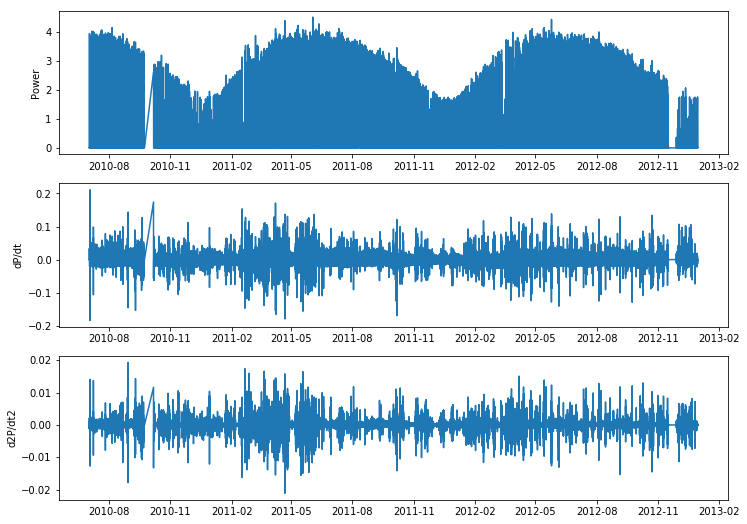

In [3]:
def get_derivatives(power):
    
    data = pd.DataFrame(index=power.index)
    data['Power'] = power

    # get the difference of the time values
    times_diff = pd.Series(data=data.index,index=data.index).diff() / pd.Timedelta('1 minute')
    times_diff.ix[0] = times_diff.ix[1] # the first entry is NaN at first
    dt = times_diff.median()

    # compute the first and second derivatives of the power
    data['deriv1'] = data['Power'].diff().divide(dt)
    data['deriv1'][0] = data['deriv1'][1]
    data['deriv2'] = data['deriv1'].diff().divide(dt)
    data['deriv2'][0] = data['deriv2'][1]

    power = data['Power']
    
    return data

data = get_derivatives(power)

# plot the power and its derivatives

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12,9))
ax_power = fig.add_subplot(311)
ax_deriv1 = fig.add_subplot(312,sharex=ax_power)
ax_deriv2 = fig.add_subplot(313,sharex=ax_power)

ax_power.plot(data['Power'])
ax_power.set_ylabel('Power')
ax_deriv1.plot(data['deriv1'])
ax_deriv1.set_ylabel('dP/dt')
ax_deriv2.plot(data['deriv2'])
ax_deriv2.set_ylabel('d2P/dt2')

## Compute a cloudiness metric from these timeseries
A day will be classified as cloudy or not based on the power and its derivatives during the day.

Since we'll be testing multiple metrics for daily cloudiness, we'll first create a class `daily_cloudiness_metric` to handle the functions we'll want to execute for each metric. The function that will compute a metric `equation` will be set after initializing each instance of the class.

In [4]:
class daily_cloudiness_metric:
    def __init__(self):
        self.nbins = 50
        self.bin_thresh = 1
        
    # this is where our metric will be defined (after creating an instance of the class)
    def equation(power):
        return None
    
    # given some data, compute the daily metric based on equation
    def compute_daily_metric(self,power):
        self.daily_metric = self.equation(power)
        
    def plot_daily_metric(self):        
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)
        ax.plot(self.daily_metric,drawstyle="steps-post")
        ax.set_ylabel('Daily cloudiness metric')
        
    def hist_daily_metric(self):
        fig = plt.figure()
        self.daily_metric.hist(bins=self.nbins)
        plt.xlabel('Cloudiness metric')
        plt.ylabel('Number of days')
        
    # based on the daily metric and the threshold, determine which days are clear
    def compute_clear_days(self,power):
        counts = self.daily_metric.value_counts(bins=self.nbins)
        self.day_is_clear = self.daily_metric < counts.index[self.bin_thresh]
        return self.day_is_clear
        
    # based on which days are clear, NaN-out times from cloudy days
    def filter(self,power):
        self.compute_daily_metric(power)
        self.compute_clear_days(power)
        time_is_clear = self.day_is_clear.reindex(index=power.index,method='ffill')
        filtered = power.copy()
        filtered[time_is_clear==False] = None
        self.filtered = filtered
        return filtered
    
    def plot_which_is_filtered(self,power):        
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)
        ax.plot(power,color='gray',label='Original')
        ax.plot(self.filtered,color='green',label='Clearsky')
        ax.set_ylabel('Power output')
        ax.legend()
        
    

### Method 1: Based just on the second derivative
From the figure above, we see the magnitude of d2P/dt2 varies much more dramatically during cloudy days. As a first step, we can integrate the square of d2P/dt2 and use that as our cloudiness metric.



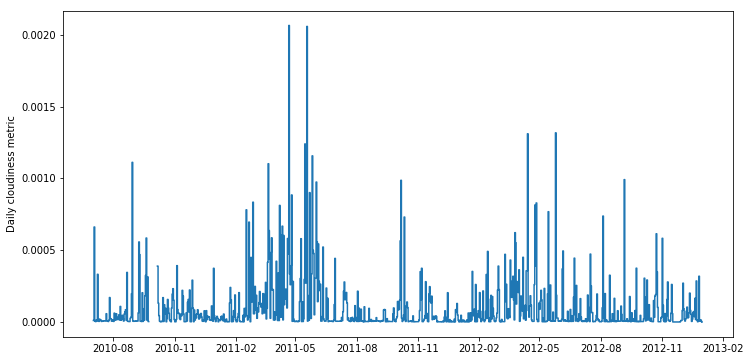

In [5]:
def f1(power):
    
    data = get_derivatives(power)
    
    m = (data['deriv2']**2).resample('1D').sum()
    
    return m

first_metric = daily_cloudiness_metric()
first_metric.equation = f1
filtered = first_metric.filter(power)

first_metric.plot_daily_metric()

View a histogram of this cloudiness metric.

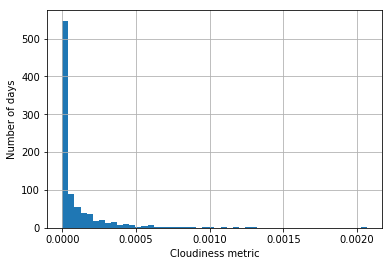

In [6]:
first_metric.hist_daily_metric()

Most days fall into the first bin; we can assume that days in the following bins are cloudy.

When we called `first_metric.filter(power)` above, this filtered out days in the following bins. The plot below shows (in green) which days fell into this first bin.

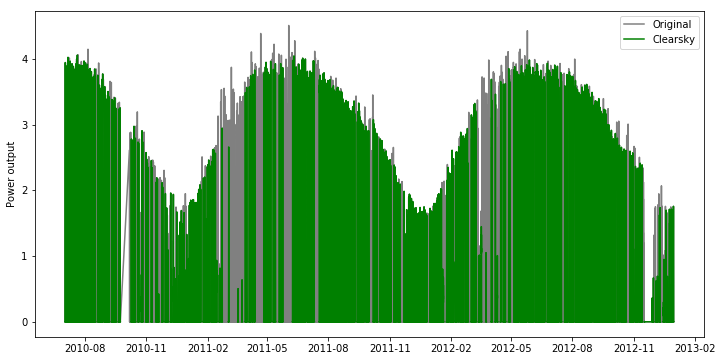

In [7]:
first_metric.plot_which_is_filtered(power)

To get a better sense for how well it's working, look at the daily profiles for a couple random days. On the left will be a plot of the daily irradiance, colored green if the day is labelled clearsky and gray if not. The plot on the right shows where in the dataset the day shown to the left lies.

Note that the y-axis limits are fixed. One some very cloudy days, the total power output is low enough that our cloudiness metric is low, and the day is labelled as clear sky.

Run the cell below a couple times to get a better sense for how well it's working.

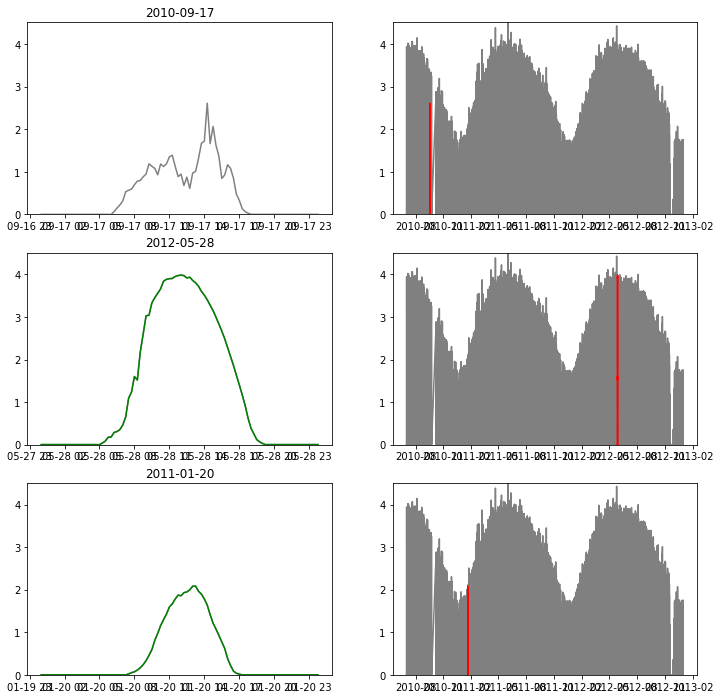

In [10]:
def view_random_days(power,filtered):

    days_to_view = power.sample(3).index

    fig = plt.figure(figsize=(12,12))

    for i,day in enumerate(days_to_view):

        ax_l = fig.add_subplot(3,2,2*i+1)
        ax_l.plot(power[power.index.date==day.date()],color='gray')
        ax_l.plot(filtered[filtered.index.date==day.date()],color='green')
        ax_l.set_ylim([0,power.max()])
        ax_l.set_title(str(day.date()))

        ax_r = fig.add_subplot(3,2,2*i+2)
        ax_r.plot(power,color='gray')
        ax_r.plot(power[power.index.date==day.date()],color='red')
        ax_r.set_ylim([0,power.max()])
        
view_random_days(power,filtered)

### Method 2: Accounting for total irradiance
The magnitude of changes in d2P/dt2 will change with the total power output: our cloudiness metric should quantify changes in d2P/dt2 in relation to the daily energy output. Start by just dividing our daily cloudiness metric (`(data['deriv2']**2).resample('1D').sum()`) by the integrated daily power (`(data['Power']).resample('1D').sum()`).

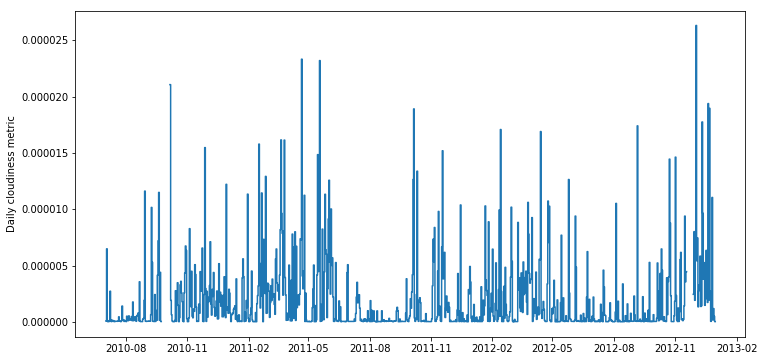

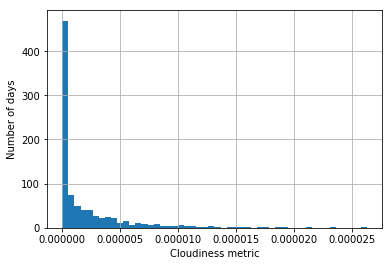

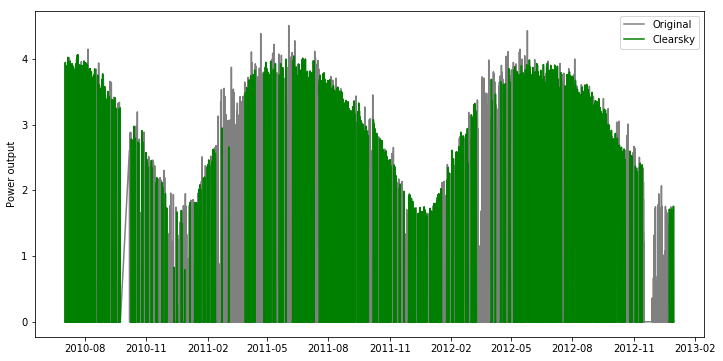

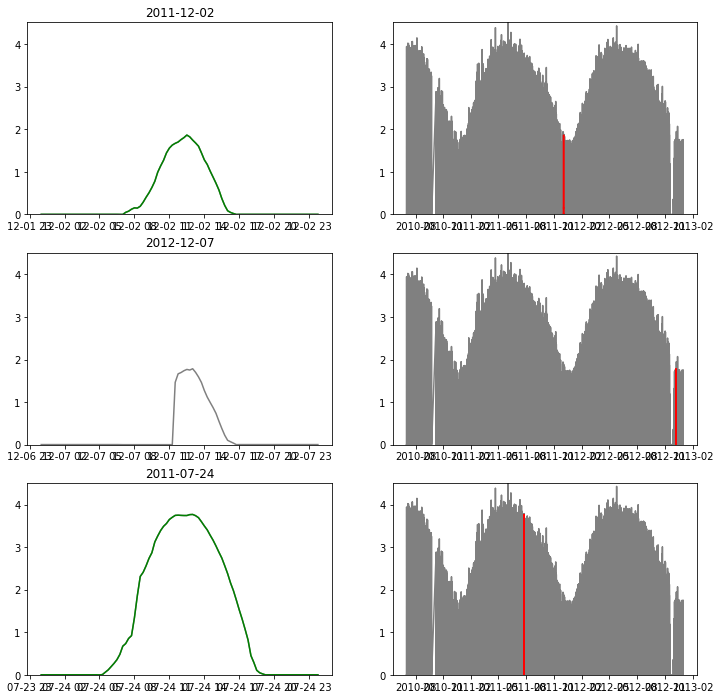

In [9]:
def f2(power):
    
    data = get_derivatives(power)
    
    m = (data['deriv2']**2).resample('1D').sum() / (data['Power']).resample('1D').sum()
    
    return m

second_metric = daily_cloudiness_metric()
second_metric.equation = f2
filtered_secondmetric = second_metric.filter(power)

second_metric.plot_daily_metric() # plot the cloudiness metric
second_metric.hist_daily_metric() # histogram of the daily cloudiness metric
second_metric.plot_which_is_filtered(power) # plot all the days, showing which is filtered

view_random_days(power,filtered_secondmetric)

Comparing these results to those obtained without dividing by the total daily output in our cloudiness metric, we see that consistently cloudy days in which output is consistently low are less likely to be labelled incorrectly as clearsky.

## Future work
- For each metric, evaluate the effect of the time of the year on how likely it is to call a day cloudy--ideally, there'd be no bias.
- Use a better method of filtering cloudy days once the metric is computed. Instead of just breaking the metric distribution into 100 bins and only keeping days in the first bin, maybe take days that only fall below some quantile of the distribution. This threshold could be changed based on the expected portion of clear days at a location.
- Look at the effect of the data's time resolution.